In [2]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import math

mean of empty:  6361.1963


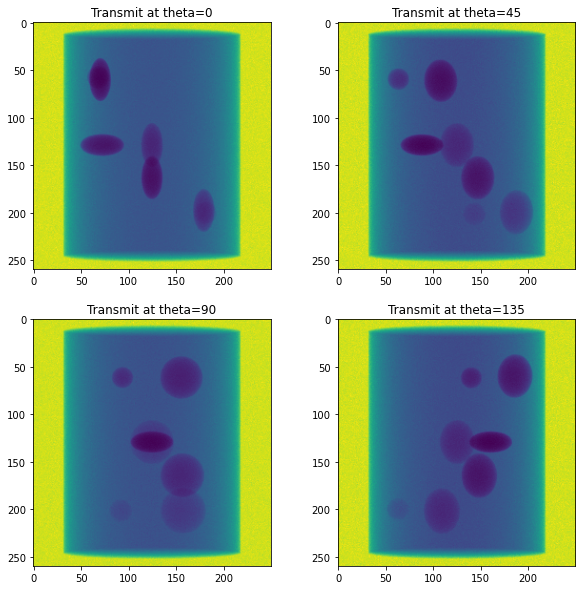

shape of projection:  (180, 260, 250)


In [3]:
nAngles=180  #number of angles (views)
Ncolumns=250 #number of columns of detector 
Nrows=260 #number of rows of detector 
step=360/nAngles
directory='/home/renqi/Documents/ct_rec/phantom_7obj/'
data_type = np.float32
file_air=directory+'ct_empty_000.dat'
data_air=np.fromfile(file_air,dtype=data_type)
print('mean of empty: ', np.mean(data_air))
projection=[]
transmit=[]
figure, axis=plt.subplots(2, 2,figsize=(10,10)) 
for i in range(0,nAngles,1):
    file_mat=directory+"ct_mat_{}.dat".format(str(i).zfill(3))   
    data_mat=np.fromfile(file_mat,dtype=data_type)
    transmit_theta=data_mat/data_air
    transmit_theta=transmit_theta.reshape(Nrows,Ncolumns)
    transmit_theta=np.fliplr(transmit_theta)
    if(i==0):
        axis[0, 0].imshow(transmit_theta)
        axis[0,0].set_title('Transmit at theta=0')
    elif(i==int(45/step)):
        axis[0, 1].imshow(transmit_theta)
        axis[0,1].set_title('Transmit at theta=45')

    elif(i==int(90/step)):
        axis[1, 0].imshow(transmit_theta)
        axis[1,0].set_title('Transmit at theta=90')

    elif(i==int(135/step)):
        axis[1, 1].imshow(transmit_theta)
        axis[1,1].set_title('Transmit at theta=135')
    projection_theta=-np.log(transmit_theta)
    projection_theta[projection_theta <  0.0]=0.0
    # plt.figure(figsize=(7,7))
    # plt.imshow(projection_theta)
    # plt.axis('off')
    # plt.savefig(directory+'projections_fig/'+"theta_{}.png".format(i*2),format='png')
    # plt.close()
    projection.append(projection_theta)
    transmit.append(transmit_theta)
projection=np.array(projection,dtype=data_type)
plt.savefig(directory+"transmit_theta.pdf",format='pdf',dpi=250)
plt.show() 
print('shape of projection: ', projection.shape)

In [4]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi
def filter_RL(N, d):
    fh_RL=np.zeros(N)
    for k1 in range(0,N,1):
        if k1 != int(N/2):     
            if int(k1-N/2) % 2 ==0:
                fh_RL[k1]=0.0
            else:
                fh_RL[k1]=-1.0/(PI*PI*((k1-N/2.0)*d)**2)
        else:
            fh_RL[int(N/2)]=1.0/(4*d**2)
    return fh_RL
def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL
def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

In [5]:
def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection
def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        # pro_fft=np.fft.fft(projection_row,Nfft)
        # filter_fft=np.fft.fft(fh_RL/2.0,Nfft)
        # convoluted_frequency=pro_fft*np.abs(filter_fft)
        # convoluted_time=np.real(np.fft.ifft(convoluted_frequency))
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    # print(XX.shape, YY.shape,ZZ.shape)
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0
    # xx[ xx < 0]=int(0) 
    # xx[ xx> Nrows-2]=int(Nrows-2)
    # yy[ yy < 0]=int(0) 
    # yy[ yy> Ncolumns-2]=int(Ncolumns-2)
    # temp=(1-u1)*(1-u2)*filtered_projection[xx,yy]+(1-u1)*u2*filtered_projection[xx,yy+1]+\
    #             (1-u2)*u1*filtered_projection[xx+1,yy]+u1*u2*filtered_projection[xx+1,yy+1]
    # temp_rec=temp_rec+temp/(np.power(U,2))*2*PI/beta_num
    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [6]:
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=Fun_Filter_Projection(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(filtered_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
    return rec_image

In [7]:
Nimage=250 #size of image
beta=np.arange(0,360,step) #rotate(view) angles
SOD=150.0 #source to origin distance, in unit mm
SDD=300.0 #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
#reconstruct the scanned object through the FBP algorithm
rec_image=ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd)

backprojection, beta:  0.0
backprojection, beta:  2.0
backprojection, beta:  4.0
backprojection, beta:  6.0
backprojection, beta:  8.0
backprojection, beta:  10.0
backprojection, beta:  12.0
backprojection, beta:  14.0
backprojection, beta:  16.0
backprojection, beta:  18.0
backprojection, beta:  20.0
backprojection, beta:  22.0
backprojection, beta:  24.0
backprojection, beta:  26.0
backprojection, beta:  28.0
backprojection, beta:  30.0
backprojection, beta:  32.0
backprojection, beta:  34.0
backprojection, beta:  36.0
backprojection, beta:  38.0
backprojection, beta:  40.0
backprojection, beta:  42.0
backprojection, beta:  44.0
backprojection, beta:  46.0
backprojection, beta:  48.0
backprojection, beta:  50.0
backprojection, beta:  52.0
backprojection, beta:  54.0
backprojection, beta:  56.0
backprojection, beta:  58.0
backprojection, beta:  60.0
backprojection, beta:  62.0
backprojection, beta:  64.0
backprojection, beta:  66.0
backprojection, beta:  68.0
backprojection, beta:  70

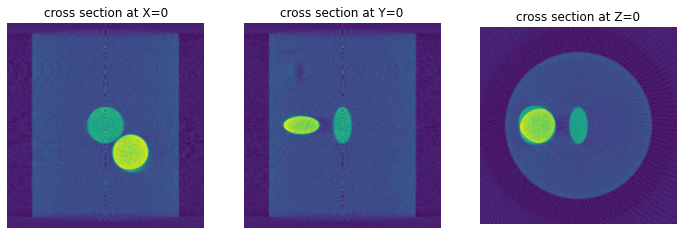

In [11]:
NimageZ=Nimage*Nrows/Ncolumns
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[X_c,:,:].T)
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T)
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,Z_c].T)
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

from mayavi import mlab
# Visualize with Mayavi
mlab.contour3d(rec_image, contours=10, opacity=0.3)
mlab.savefig(directory+'rec_image3D.png')
mlab.show()